### Moving Average Convergence Divergence Strategy

<font color='orange'>
    Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between a short-term and a long-term moving average of a security’s price, where normally:
    $$
    M A C D=\operatorname{12-period} E M A − \operatorname{26-period} E M A
    $$
    MACD line shows the trend of price movement:
    <ul>
        <li>$MACD < 0$:</li>
        Market is going through a bearish trend
        <li>$MACD > 0$:</li>
        Market is going through a bullish trend
    </ul>
    Divergence in this case refers to a situation where price action and momentum are not acting together, that comprises of 2 scenarios:
    <ul>
        <li>Bearish divergence:</li>
        If price reaches higher highs, while MACD fails to reach higher highs
        <li>Bullish divergence:</li>
        If price reaches lower lows, while MACD fails to reach lower lows
    </ul>
</font>

<font color='orange'>
    MACD strategy has multiple variants:
    <ol>
        <li>Cross-over strategy:</li>
        On the MACD chart, a 9-period EMA of the MACD itself is also plotted which is called signal line. The MACD generates a bullish signal when it moves above the signal line and vice versa. The MACD is considered the faster line here because the points plotted move more than the signal line, which is regarded as the slower line.
        <li>Zero-cross strategy:</li>
        When the MACD crosses from below the zero line, it is considered a bullish signal, and vice versa.
    </ol>  
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
from datetime import datetime
from collections import namedtuple
import math
from numbers import Real
import jdc
plt.style.use('seaborn')

/var/folders/6b/zsc6z0x51ls8w8wy4m79d0y80000gn/T/ipykernel_69320/913403548.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


> #### Implementation:

In [2]:
class MACD:
    '''
    Description: 
        Class for the vectorized backtesting of MACD-based trading strategies.

    Properties:
    ===========
    symbol: str
        ticker symbol
    ema_s: int
        time window in days for shorter EMA
    ema_l: int
        time window in days for longer EMA
    signal_window: int 
        time window in days for MACD signal line
    start_date: str or datetime
        start date for data retrieval
    end_date: str or datetime
        end date for data retrieval
    tc: Real
        proportional transaction costs per trade

    Methods:
    ========
    load_data:
        retrieve and prepare data given a file path
    prepare_data:
        prepare data
    run_strategy:
        run the backtest for the MACD cross-over strategy
    run_with_updated_params:
        update MACD parameters and rerun strategy
    optimize_params:
        implement a brute force optimization to search for optimal MACD parameters
    plot_result:
        plot the performance of the MACD strategy compared to buy-and-hold strategy
    '''
    def __init__(self, symbol, ema_s, ema_l, signal_window, start_date, end_date, tc):
        self._symbol = symbol
        self._ema_s = ema_s
        self._ema_l = ema_l
        self._signal_window = signal_window
        self._start_date = start_date
        self._end_date = end_date
        self._tc = tc
        self.data = None
        self.path = None
        self.result = None
        self.perf = None

    def __repr__(self):
        return f'MACDBackTester(symbol: {self.symbol}, ema_short: {self.ema_s}, ema_long: {self.ema_l}, signal_window: {self.signal_window}, start_date: {self.start_date}, end_date: {self.end_date})'
    
    # Symbol
    @property
    def symbol(self):
        return self._symbol
    @symbol.setter
    def symbol(self, symbol):
        if isinstance(symbol, str):
            self._symbol = symbol
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Symbol must be a string.')

    # Ema_short
    @property
    def ema_s(self):
        return self._ema_s
    @ema_s.setter
    def ema_s(self, ema_s):
        if isinstance(ema_s, int):
            self._ema_s = ema_s
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Ema_short must be an integer.')

    # Ema_long
    @property
    def ema_l(self):
        return self._ema_l
    @ema_l.setter
    def ema_l(self, ema_l):
        if isinstance(ema_l, int):
            self._ema_l = ema_l
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Ema_long must be an integer.')
            
    # Signal_window
    @property
    def signal_window(self):
        return self._signal_window
    @signal_window.setter
    def signal_window(self, signal_window):
        if isinstance(signal_window, int):
            self._signal_window = signal_window
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Signal_window must be an integer.')

    # Start_date
    @property
    def start_date(self):
        return self._start_date
    @start_date.setter
    def start_date(self, start_date):
        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    # End_date
    @property
    def end_date(self):
        return self._end_date
    @end_date.setter
    def end_date(self, end_date):
        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    @property
    def tc(self):
        return self._tc
    @tc.setter
    def tc(self, tc):
        if isinstance(tc, Real):
            self._tc = tc
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Trading_cost must be a real number.')

In [3]:
%%add_to MACD
def load_data(self, path):
    '''
    Retrieve and prepare the data given a file path.
    '''
    if isinstance(path, str):
        self.path = path
    else:
        raise ValueError('File path of data must be a string.')
    self.prepare_data()

In [4]:
%%add_to MACD
def prepare_data(self):
    '''
    Prepare data.
    '''
    # Load data
    self.data = pd.read_csv(self.path, parse_dates=['Date'], index_col='Date')
    # Filter data for given symbol
    self.data = self.data[self.symbol].to_frame().dropna()
    # Filter data for given period
    self.data = self.data.loc[self.start_date : self.end_date].copy()
    self.data.rename(columns={self.symbol: 'Price'}, inplace=True)
    
    # ema_short
    self.data['EMA_S'] = self.data['Price'].ewm(span=self.ema_s, min_periods=self.ema_s).mean()
    # ema_long
    self.data['EMA_L'] = self.data['Price'].ewm(span=self.ema_l, min_periods=self.ema_l).mean()
    # macd
    self.data['MACD'] = self.data['EMA_S'] - self.data['EMA_L']
    # macd signal
    self.data['MACD_Signal'] = self.data['MACD'].ewm(span=self.signal_window, min_periods=self.signal_window).mean()
    
    # Return of buy-and-hold strategy
    return_buy_and_hold = self.data['Price'] / self.data['Price'].shift(1)
    # Return (log) of buy-and-hold strategy
    self.data['Return_Buy_Hold(log)'] = np.log(return_buy_and_hold)
    # Cumulative return of buy-and-hold strategy
    self.data['Return_Buy_Hold(cum)'] = self.data['Return_Buy_Hold(log)'].cumsum().apply(np.exp)

In [5]:
%%add_to MACD
def run_strategy(self):
    '''
    Backtest the MACD cross-over strategy.
    '''
    data = self.data.copy().dropna()
    # If macd > macd_signal, hold long position and otherwise short
    data['Position'] = np.where(data['MACD'] > data['MACD_Signal'], 1, -1)
    # Number of trades
    data['Trades'] = data['Position'].diff().fillna(0).abs()
    
    # Return of ema strategy (position of previous day * return of current day)
    data['Return_MACD(log)'] = data['Position'].shift(1) * data['Return_Buy_Hold(log)']
    data.dropna(inplace=True)
    # Return of ema strategy (excluding trading cost)
    data['Return_MACD_Net(log)'] = data['Return_MACD(log)'] - data['Trades'] * self.tc
    
    # Cumulative return of ema strategy
    data['Return_MACD(cum)'] = data['Return_MACD(log)'].cumsum().apply(np.exp)
    # Cumulative return of ema strategy (excluding trading cost)
    data['Return_MACD_Net(cum)'] = data['Return_MACD_Net(log)'].cumsum().apply(np.exp)
    self.result = data

    abs_perf = self.result['Return_MACD(cum)'].iloc[-1]
    out_perf = abs_perf - data['Return_Buy_Hold(cum)'].iloc[-1]

    self.perf = namedtuple('macd_performance', ['macd_abs_performance', 'macd_out_performance'])
    self.perf.macd_abs_performance = round(abs_perf, 6)
    self.perf.macd_out_performance = round(out_perf, 6)
    return self.perf.macd_abs_performance

In [6]:
%%add_to MACD
def run_with_updated_params(self, macd):
    '''
    update MACD parameters and rerun strategy.

    Parameters:
    ===========
    macd: tuple
        macd parameter tuple
    '''
    self.ema_s = int(macd[0])
    self.ema_l = int(macd[1])
    self.signal_window = int(macd[2])
    return -self.run_strategy()

In [7]:
%%add_to MACD
def optimize_params(self, ema_s_range, ema_l_range, signal_window_range):
    '''
    Find optimal MACD parameters in terms of best possible MACD return.
    
    Parameters:
    ===========
    ema_s_range, ema_l_range, signal_window_range: tuple
        macd ranges tuples      
    '''
    opt = brute(self.run_with_updated_params, ranges=(ema_s_range, ema_l_range, signal_window_range), finish=None)
    return opt

In [8]:
%%add_to MACD
def plot_result(self):
    '''
    Plots the cumulative performance of the MACD strategy comparing to buy-and-hold.
    '''
    if self.result is None:
        print('No result for display, please run the strategy')
    else:
        title = f'{self.symbol} | MACD (EMA_S = {self.ema_s}, EMA_L = {self.ema_l}, Signal_Window = {self.signal_window}) | TC = {self.tc}'
        self.result[['Return_Buy_Hold(cum)', 'Return_MACD(cum)', 'Return_MACD_Net(cum)']].plot(title=title, figsize=(12, 8))        

> #### Example:

In [9]:
PATH = './data/forex_pairs.csv'

EMA_SHORT = 12
EMA_LONG = 26
SIGNAL_WINDOW = 9
EMA_S_RANGE = (5, 20, 1)
EMA_L_RANGE = (21, 50, 1)
SIGNAL_WINDOW_RANGE = (5, 20, 1)

SYMBOL = 'EURUSD=X'
START_DATE = '2004-01-01'
END_DATE = '2020-06-30'
TRADING_COST = 0.00007

In [10]:
macd = MACD(symbol=SYMBOL, 
            ema_s=EMA_SHORT, 
            ema_l=EMA_LONG,
            signal_window=SIGNAL_WINDOW,
            start_date=START_DATE,
            end_date=END_DATE,
            tc=TRADING_COST)
macd

MACDBackTester(symbol: EURUSD=X, ema_short: 12, ema_long: 26, signal_window: 9, start_date: 2004-01-01, end_date: 2020-06-30)

In [11]:
macd.load_data(path = PATH)
macd.data.head()

,Price,EMA_S,EMA_L,MACD,MACD_Signal,Return_Buy_Hold(log),Return_Buy_Hold(cum)
Date,,,,,,,
2004-01-01,1.258194,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-02,1.258194,NaN,NaN,NaN,NaN,0.000000,1.000000
2004-01-05,1.268698,NaN,NaN,NaN,NaN,0.008313,1.008348
2004-01-06,1.272103,NaN,NaN,NaN,NaN,0.002681,1.011055
2004-01-07,1.264095,NaN,NaN,NaN,NaN,-0.006315,1.004690


In [12]:
macd.run_strategy()
macd.result.head()

,Price,EMA_S,EMA_L,MACD,MACD_Signal,Return_Buy_Hold(log),Return_Buy_Hold(cum),Position,Trades,Return_MACD(log),Return_MACD_Net(log),Return_MACD(cum),Return_MACD_Net(cum)
Date,,,,,,,,,,,,,
2004-02-18,1.272508,1.271449,1.266693,0.004756,0.003408,-0.010386,1.011376,1,0.0,-0.010386,-0.010386,0.989667,0.989667
2004-02-19,1.275705,1.272106,1.267405,0.004700,0.003691,0.002510,1.013918,1,0.0,0.002510,0.002510,0.992154,0.992154
2004-02-20,1.254202,1.269345,1.266367,0.002978,0.003538,-0.017000,0.996827,-1,2.0,-0.017000,-0.017140,0.975430,0.975294
2004-02-23,1.257197,1.267473,1.265649,0.001824,0.003175,0.002386,0.999208,-1,0.0,-0.002386,-0.002386,0.973106,0.972969
2004-02-24,1.267797,1.267523,1.265817,0.001706,0.002868,0.008395,1.007632,-1,0.0,-0.008395,-0.008395,0.964970,0.964835


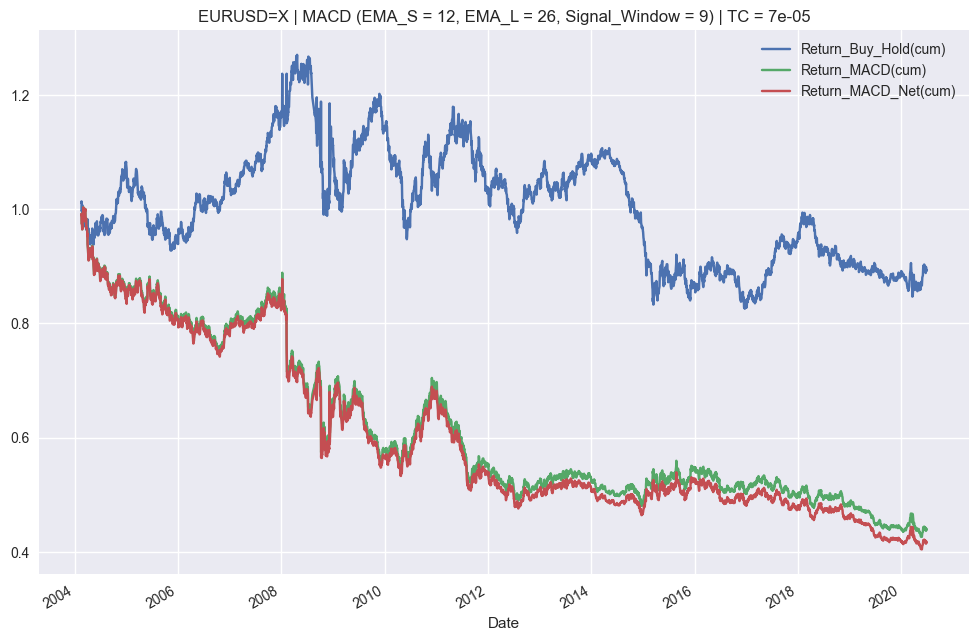

In [13]:
macd.plot_result()

In [14]:
macd.optimize_params(ema_s_range=EMA_S_RANGE, ema_l_range=EMA_L_RANGE, signal_window_range=SIGNAL_WINDOW_RANGE)

array([18., 30., 19.])